<a href="https://colab.research.google.com/github/promise32/myrep2/blob/main/TitanicSpaceshippred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Predict which passengers are transported to an alternate dimension**

##Project Description:
The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!
To help rescue crews and retrieve the lost passengers, there is a challenge to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

#Column Description
###PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
###HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
###CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
###Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
###Destination - The planet the passenger will be debarking to.
###Age - The age of the passenger.
###VIP - Whether the passenger has paid for special VIP service during the voyage.
###RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
###Name - The first and last names of the passenger.
###Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

#Data Collection

In [1]:
# install the opendatasets package
!pip install opendatasets

import opendatasets as od

# download the dataset (this is a Kaggle dataset)
# during download you will be required to input your Kaggle username and password
od.download("https://www.kaggle.com/competitions/spaceship-titanic/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: promise91
Your Kaggle Key: ··········


100%|██████████| 299k/299k [00:00<00:00, 47.3MB/s]


Extracting archive ./spaceship-titanic/spaceship-titanic.zip to ./spaceship-titanic


In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn.tree as tree
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')

In [3]:
test = pd.read_csv('spaceship-titanic/test.csv')
train=pd.read_csv('spaceship-titanic/train.csv')
submission=pd.read_csv('spaceship-titanic/sample_submission.csv')

#Data Wrangling

In [4]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [5]:
train1=train.dropna()

In [6]:
train1['Transported'].replace({False: 0, True: 1}, inplace= True)

In [7]:
train1['CryoSleep'].replace({False: 0, True: 1}, inplace= True)

In [8]:
train1['VIP'].replace({False: 0, True: 1}, inplace= True)

In [9]:
train1.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [10]:
target=train1['Transported']
train1.drop(['Transported'], axis=1, inplace=True)

In [11]:
Titandata=train1.append(test)

In [12]:
Titandata.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [13]:
Titandata.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [15]:

imp=IterativeImputer(random_state=42)
date=pd.Timestamp('2200-01-01')
for col in Titandata:
  if Titandata[col].dtype=="object":
    Titandata[col].fillna("Not listed", inplace=True)
  if Titandata[col].dtype=="int":
    Titandata[col].fillna(Titandata[col].mean(), inplace=True)
  if Titandata[col].dtype=='float':
    Titandata[col]= imp.fit_transform(Titandata[col].values.reshape(-1, 1))
  if Titandata[col].dtype=='datetime64[ns]':
     Titandata[col].fillna(date, inplace=True)
Titandata.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [16]:
Titandata.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64

In [17]:


Titandata['Age Group'] = pd.cut(Titandata['Age'], bins=[-1, 18, 40, 65, 100], labels=['Child','Young adult','Middle age', 'Elderly'])
Titandata.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Age Group
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,Young adult
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,Young adult
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,Middle age
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,Young adult
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,Child


##Explorative Data Analysis

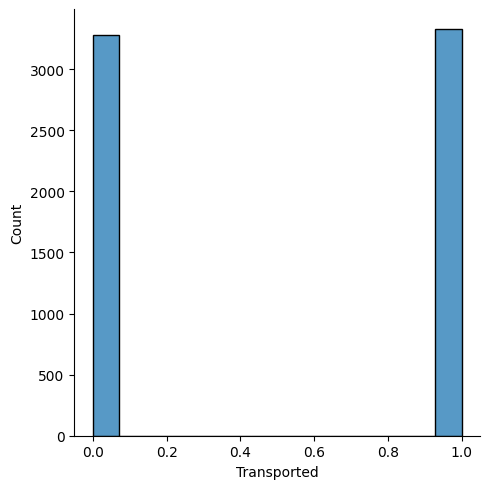

In [18]:
sns.displot(target)

In [19]:
trans_count=target.value_counts()
trans_count

1    3327
0    3279
Name: Transported, dtype: int64

In [20]:
trans_percent=trans_count/len(train1)
trans_percent

1    0.503633
0    0.496367
Name: Transported, dtype: float64

In [21]:
Titandata.dtypes

PassengerId       object
HomePlanet        object
CryoSleep         object
Cabin             object
Destination       object
Age              float64
VIP               object
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Name              object
Age Group       category
dtype: object

In [22]:
Titandata.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,10883.000000,10883.000000,10883.000000,10883.000000,10883.000000,10883.000000
mean,28.802539,221.544764,463.680894,177.945387,309.246151,306.472369
std,14.336493,628.104166,1613.968607,567.769771,1128.385393,1170.778683
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,60.000000,96.500000,37.000000,71.000000,52.000000
max,79.000000,11567.000000,29813.000000,12253.000000,22408.000000,22272.000000


In [23]:
Titandata.to_csv('Titanic_Data')

In [24]:
Titandata.corr()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Age,1.000000,0.070337,0.125264,0.040579,0.116896,0.103374
RoomService,0.070337,1.000000,-0.019234,0.061267,0.010190,-0.028420
FoodCourt,0.125264,-0.019234,1.000000,0.001867,0.223621,0.238502
ShoppingMall,0.040579,0.061267,0.001867,1.000000,0.015002,0.011338
Spa,0.116896,0.010190,0.223621,0.015002,1.000000,0.145698
VRDeck,0.103374,-0.028420,0.238502,0.011338,0.145698,1.000000


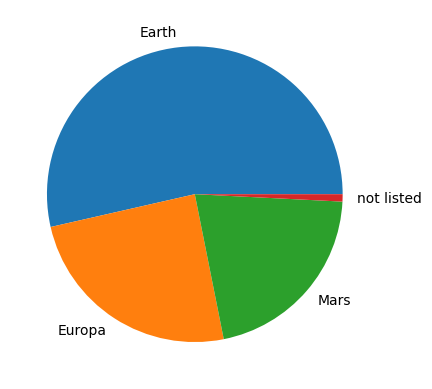

In [25]:
Lebels= ["Earth", "Europa", "Mars","not listed"]
home_count=Titandata['HomePlanet'].value_counts()
homper= home_count/len(Titandata)
plt.pie(homper, labels=Lebels)
plt.show()


In [26]:
home_count

Earth         5829
Europa        2675
Mars          2292
Not listed      87
Name: HomePlanet, dtype: int64

In [27]:
homper

Earth         0.535606
Europa        0.245796
Mars          0.210604
Not listed    0.007994
Name: HomePlanet, dtype: float64

In [28]:
Titandata.Age.value_counts()

18.0    431
24.0    413
22.0    397
19.0    387
21.0    384
       ... 
79.0      4
78.0      4
75.0      4
76.0      2
77.0      2
Name: Age, Length: 81, dtype: int64

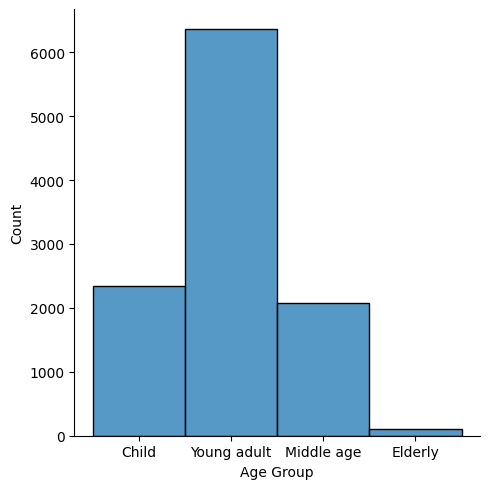

In [29]:
sns.displot(Titandata['Age Group'])

In [30]:
Titandata['Age Group'].replace({'Child': 1, 'Young adult': 2, 'Middle age': 3, 'Elderly': 4 },inplace=True )

In [31]:
Titandata[["Age"]] = Titandata[["Age"]].astype("int")

In [32]:
Titandata['HomePlanet'].replace({'Earth': 1, 'Europa': 2, 'Mars': 3, 'Not listed': 4}, inplace= True)

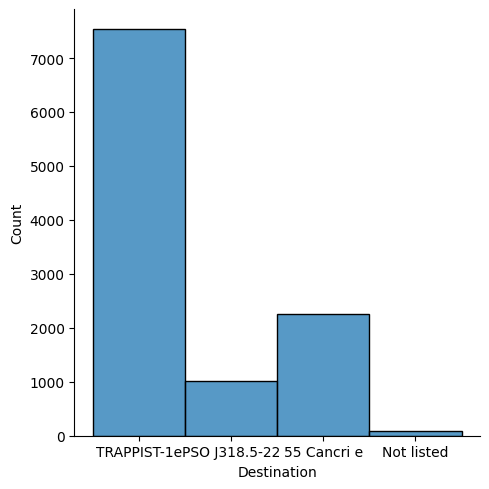

In [33]:
sns.displot(Titandata.Destination)

In [34]:
pd.crosstab(Titandata['Age'], Titandata['HomePlanet'], normalize = True)

HomePlanet,1,2,3,4
Age,,,,
0,0.015069,0.000827,0.004502,0.000000
1,0.005329,0.000368,0.001562,0.000184
2,0.005881,0.000827,0.001470,0.000092
3,0.006524,0.000184,0.002113,0.000000
4,0.005238,0.000459,0.001378,0.000000
...,...,...,...,...
75,0.000092,0.000092,0.000184,0.000000
76,0.000000,0.000092,0.000092,0.000000
77,0.000092,0.000092,0.000000,0.000000


In [35]:
Titandata['HomePlanet']

0       2
1       1
2       2
3       2
4       1
       ..
4272    1
4273    1
4274    3
4275    2
4276    1
Name: HomePlanet, Length: 10883, dtype: int64

In [36]:
Titandata['HomePlanet'].replace({'Earth': 1, 'Europa': 2, 'Mars': 3, 'Not listed': 4}, inplace= True)

In [37]:
Titandata['CryoSleep'][Titandata['CryoSleep']=='Not listed']= False

In [38]:
print(Titandata.iloc[6674])

PassengerId         0156_01
HomePlanet                3
CryoSleep             False
Cabin                F/34/P
Destination     TRAPPIST-1e
Age                      28
VIP                   False
RoomService             0.0
FoodCourt               0.0
ShoppingMall            0.0
Spa                     0.0
VRDeck                  0.0
Name            Tures Upead
Age Group                 2
Name: 68, dtype: object


In [39]:

Titandata['CryoSleep'].replace({False: 0, True:1}, inplace=True)

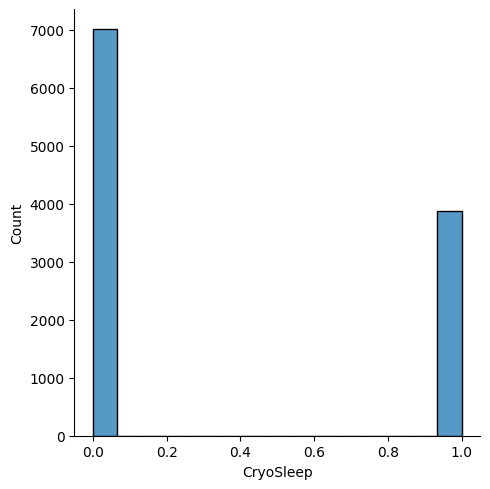

In [40]:
sns.displot(Titandata['CryoSleep'])

In [41]:
Titandata['VIP'].replace({False: 0, True:1}, inplace=True)

In [42]:
Titandata['VIP'][Titandata['VIP']=='Not listed']= False

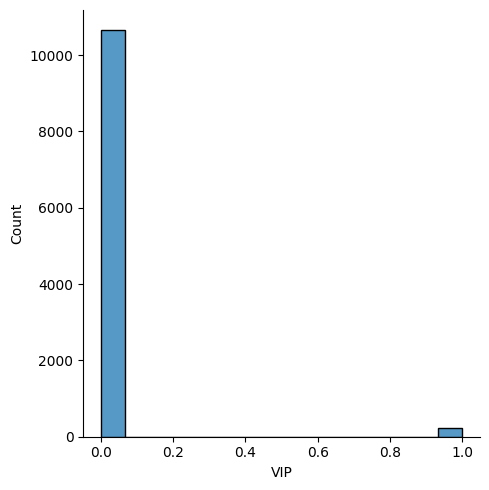

In [43]:
sns.displot(Titandata['VIP'])

In [44]:
Titandata['Destination'].replace({'TRAPPIST-1e': 1,'PSO J318.5-22': 2, '55 Cancri e': 3, 'Not listed': 4 },inplace=True)

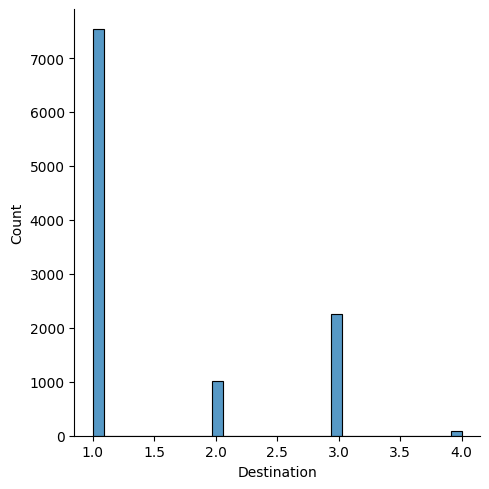

In [45]:
sns.displot(Titandata['Destination'])

In [46]:
dummy_variable_1 = pd.get_dummies(Titandata["Cabin"])


In [47]:
df = pd.concat([Titandata, dummy_variable_1], axis=1)
df.drop("Cabin", axis = 1, inplace=True)

In [48]:
Titandata.size

152362

#Feature Engineering

In [49]:
DR= ['Name','PassengerId']
df.drop(DR, axis=1, inplace=True)

In [50]:
Titandata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10883 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   10883 non-null  object  
 1   HomePlanet    10883 non-null  int64   
 2   CryoSleep     10883 non-null  int64   
 3   Cabin         10883 non-null  object  
 4   Destination   10883 non-null  int64   
 5   Age           10883 non-null  int64   
 6   VIP           10883 non-null  object  
 7   RoomService   10883 non-null  float64 
 8   FoodCourt     10883 non-null  float64 
 9   ShoppingMall  10883 non-null  float64 
 10  Spa           10883 non-null  float64 
 11  VRDeck        10883 non-null  float64 
 12  Name          10883 non-null  object  
 13  Age Group     10883 non-null  category
dtypes: category(1), float64(5), int64(4), object(4)
memory usage: 1.2+ MB


In [51]:
Titandata[["Age Group"]] = Titandata[["Age Group"]].astype("int")

In [53]:
Features= ['HomePlanet', 'CryoSleep', 'Destination', 'Age Group', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
y=target
X=Titandata[Features][:len(train1)]
X_test= Titandata[Features][len(train1):]

<Axes: >

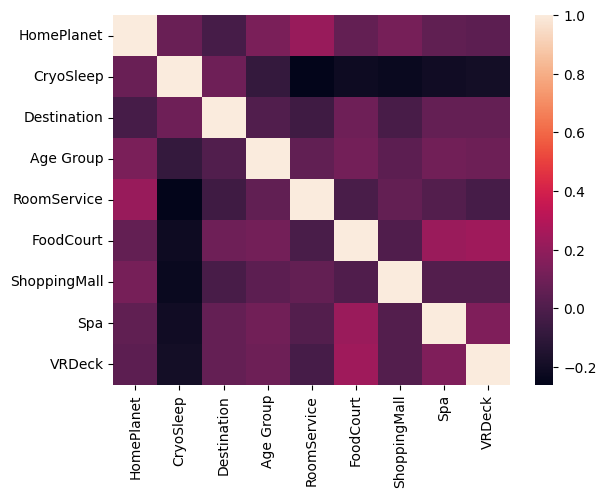

In [54]:
cmap=Titandata[Features].corr()
sns.heatmap(cmap)

In [55]:
from sklearn import preprocessing
transform = preprocessing.StandardScaler()
X = preprocessing.StandardScaler().fit(X).transform(X)
#X[0:3]

##Machine Learning and Predictions

##Model selection with Logistic Regression using the Gridsearch object

In [57]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=3, stratify=y, shuffle=True)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((5945, 9), (5945,), (661, 9), (661,), (4277, 9))

In [58]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
GSCV=GridSearchCV(lr, parameters, scoring='accuracy', cv=10)
logreg_cv=GSCV.fit(X_train, y_train)

In [59]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.7828509181450359


In [67]:
y_pred=logreg_cv.predict(X_val)
logregaccu=logreg_cv.score(X_val, y_val)

In [68]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[260  68]
 [ 72 261]]


In [69]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
import sklearn.metrics as metrics

In [70]:
predict_proba = logreg_cv.predict_proba(X_val)


In [71]:
Logreg_JaccardIndex= jaccard_score(y_val, y_pred, average='weighted')
Logreg_F1_Score = f1_score(y_val, y_pred, average='weighted')
Logreg_Log_Loss= log_loss(y_val, predict_proba)

####Model selection with Descision Tree Classifier Machine using the Gridsearch object

In [72]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [74]:
tree_cv=GridSearchCV(tree, parameters, scoring='accuracy',cv=10)
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [75]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.7815018532665591


In [76]:
Tree_Accuracy=tree_cv.score(X_val,y_val)
Tree_Accuracy

0.7760968229954615

In [77]:

predic3=tree_cv.predict(X_val)
Tree_JaccardIndex = jaccard_score(y_val, predic3, average='weighted')
Tree_F1_Score = f1_score(y_val, predic3, average='weighted')

In [78]:
print(confusion_matrix(y_val, predic3))

[[239  89]
 [ 59 274]]


####Model selection with KNN using the Gridsearch object

In [79]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [80]:
knn_cv=GridSearchCV(KNN, parameters, scoring='accuracy', cv=10)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]},
             scoring='accuracy')

In [81]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'brute', 'n_neighbors': 9, 'p': 2}
accuracy : 0.778640466287525


In [82]:
predic4=knn_cv.predict(X_val)

In [83]:
KNN_Accuracy=knn_cv.score(X_val, y_val)
KNN_Accuracy

0.7745839636913767

In [84]:
print(confusion_matrix(y_val, predic4))

[[246  82]
 [ 67 266]]


In [85]:

knn_JaccardIndex = jaccard_score(y_val, predic3, average='weighted')
knn_F1_Score = f1_score(y_val, predic3, average='weighted')

####Model selection with Support vector Machine

In [86]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [87]:
yhat = clf.predict(X_val)
yhat [0:5]

array([1, 1, 0, 1, 0])

In [88]:
svc=clf.score(X_val, y_val)
svc

0.800302571860817

In [89]:
print(confusion_matrix(y_val, yhat))

[[265  63]
 [ 69 264]]


In [90]:

SVM_JaccardIndex = jaccard_score(y_val, yhat, average='weighted')
SVM_F1_Score = f1_score(y_val, yhat, average='weighted')

##Model Evaluation

In [91]:
data = {
    'Model': ['KNearestNeighbour', 'Decision Tree', 'Logistic Regression', 'Support Vector Machine'],
    'Model Accuracy': [KNN_Accuracy,Tree_Accuracy,logregaccu,svc, ],
    'F1 Score': [knn_F1_Score,Tree_F1_Score,Logreg_F1_Score,SVM_F1_Score],
    'Log Loss': [None,None,Logreg_Log_Loss,None],
    'Jaccard Index': [knn_JaccardIndex,Tree_JaccardIndex,Logreg_JaccardIndex,SVM_JaccardIndex]}


# Create a DataFrame from the dictionary
Report = pd.DataFrame(data)

# Display the report
Report

,Model,Model Accuracy,F1 Score,Log Loss,Jaccard Index
0,KNearestNeighbour,0.774584,0.775557,NaN,0.633550
1,Decision Tree,0.776097,0.775557,NaN,0.633550
2,Logistic Regression,0.788200,0.788202,0.453955,0.650440
3,Support Vector Machine,0.800303,0.800300,NaN,0.667083


In [92]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')  # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.7.1


In [93]:
import plotly.express as px

In [94]:
fig = px.bar(Report, x="Model", y="Model Accuracy", title='Accuracy Visualization of Selected Prediction Models', width=1000, height=600)
fig.show()

In [95]:
fig = px.bar(Report, x="Model", y="F1 Score", title='Accuracy Visualization of Selected Prediction Models', width=1000, height=600)
fig.show()

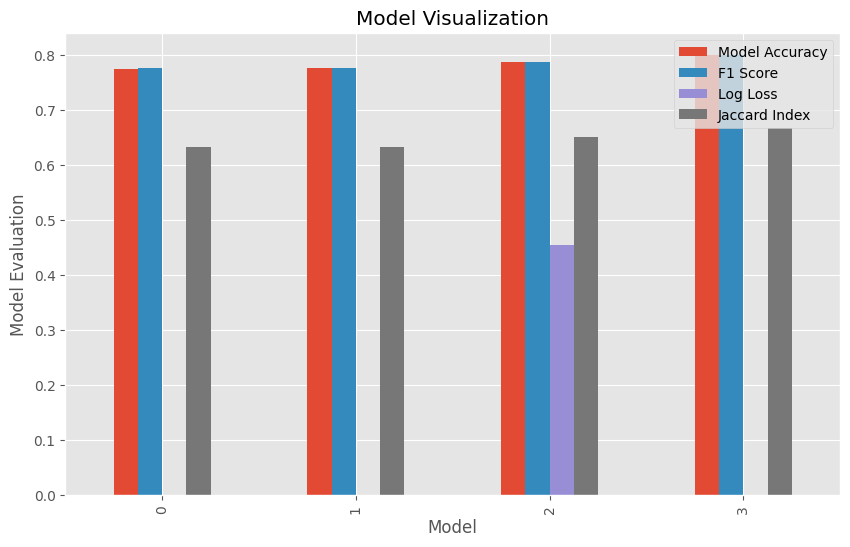

In [96]:
Report.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Model') # add to x-label to the plot
plt.ylabel('Model Evaluation') # add y-label to the plot
plt.title('Model Visualization') # add title to the plot
plt.show()

In [100]:
predictions= logreg_cv.predict(X_test)
predictions= predictions.astype(str)
predictions=np.char.replace(predictions, '0', 'False')
predictions=np.char.replace(predictions, '1', 'True')
predictions

array(['True', 'False', 'True', ..., 'True', 'True', 'True'], dtype='<U5')

In [98]:
predictions.shape

(661,)

In [104]:
submission['Transported']=predictions
submission.to_csv('submission.csv', index=False)
my_submission=pd.read_csv('submission.csv')
my_submission.head(30)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
5,0027_01,True
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True
